# Assignment 2. Deep learning on images

## Group 23

## Loading data

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

path_meta = 'http://seppe.net/aa/assignment2/metadata.json'

target = pd.read_json(path_meta).T
target.head()

,has_pool,center,bounds_lat_lon,bounds_x_y
42.7363609_2.8868181.png,True,"{'lat': 42.7363609, 'lon': 2.8868181}","[{'lat': 42.7364046, 'lon': 2.8867693}, {'lat'...","[{'x': 219.88854424638464, 'y': 197.9724640370..."
42.7008031_2.906998.png,True,"{'lat': 42.7008031, 'lon': 2.9069979999999997}","[{'lat': 42.700821, 'lon': 2.9069484}, {'lat':...","[{'x': 219.31757991040274, 'y': 223.9864984406..."
42.6892307_2.9110119.png,True,"{'lat': 42.6892307, 'lon': 2.9110119}","[{'lat': 42.6891823, 'lon': 2.9110157}, {'lat'...","[{'x': 258.80982304681845, 'y': 290.6887228406..."
44.5015552_0.1670612.png,True,"{'lat': 44.5015552, 'lon': 0.1670612}","[{'lat': 44.5015798, 'lon': 0.1670115999999999...","[{'x': 218.20287511855798, 'y': 215.7165834111..."
43.3741395_3.3383116.png,True,"{'lat': 43.3741395, 'lon': 3.3383116}","[{'lat': 43.3742033, 'lon': 3.3383698}, {'lat'...","[{'x': 299.5176070846709, 'y': 176.37075727338..."


In [2]:
target['has_pool'].value_counts()

True    14964
Name: has_pool, dtype: int64

In [3]:
import os
import cv2
from tqdm import tqdm

data = []
IMAGE_SIZE = 100
path = 'images'

def loading_images():
    for img in tqdm(os.listdir(path)):
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
        target_polygon = target.loc[img, 'bounds_x_y']
        data.append([new_array, target_polygon])

loading_images()
    

100%|████████████████████████████████████████████████████████████████████████████| 14912/14912 [03:28<00:00, 71.46it/s]


After matching the features and target values and shiffling them, we can separate into separate lists. 

In [4]:
import random

random.seed(12345)
random.shuffle(data)

In [5]:
X = []
y = []

for features, target in data:
    X.append(features)
    y.append(target)

In [6]:
#normalizing the coordinates by dividing the original image size
rect_norm = []
for img in y:
    rect_coord = []
    x_coord = []
    y_coord = []
    for point in img:
        x_coord.append(point['x']/512)
        y_coord.append(point['y']/512)
    rect_coord = [min(x_coord), min(y_coord), max(x_coord), max(y_coord)]
    rect_norm.append(rect_coord)

rect_norm[0]

[0.42237269311534403,
 0.38111052512319377,
 0.5777737735135693,
 0.564403993453031]

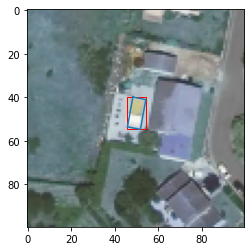

In [7]:
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

IMAGE_SIZE = 100

im_num = 1358
fig, ax = plt.subplots()
ax.imshow(cv2.resize(X[im_num], (IMAGE_SIZE, IMAGE_SIZE)))

rect = patches.Rectangle([rect_norm[im_num][0]*IMAGE_SIZE,rect_norm[im_num][1]*IMAGE_SIZE], \
                         (rect_norm[im_num][2]-rect_norm[im_num][0])*IMAGE_SIZE, \
                         (rect_norm[im_num][3]-rect_norm[im_num][1]) *IMAGE_SIZE, linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

coord = []
for i in y[im_num]:
    coord.append([i['x']/512*IMAGE_SIZE, i['y']/512*IMAGE_SIZE])
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

ax.plot(xs,ys) 
plt.show() 

In [8]:
import numpy as np

X = np.array(X).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
print(X.shape)

y = np.array(rect_norm).reshape(-1, 4)
print(y.shape)

(14912, 100, 100, 3)
(14912, 4)


In [9]:
import pickle

pickle_out = open("data/X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("data/y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()


## Building model 

In [10]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img


In [11]:
import pickle

pickle_in = open("data/X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("data/y.pickle","rb")
y = pickle.load(pickle_in)
pickle_in.close()

In [12]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
input_tensor=Input(shape=(100, 100, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [14]:
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [15]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=5,
    verbose=1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [16]:
model.save('saved_model/model_2')

INFO:tensorflow:Assets written to: saved_model/model_2\assets


INFO:tensorflow:Assets written to: saved_model/model_2\assets


In [17]:
from tensorflow.keras.models import load_model

model = load_model('saved_model/model_2')

1/1 [==============================] - 0s 302ms/step
[0.4355885 0.4152109 0.5660234 0.5395979]


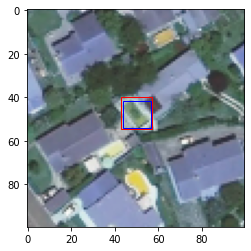

1/1 [==============================] - 0s 96ms/step
[0.40510488 0.38051966 0.5704962  0.5519551 ]


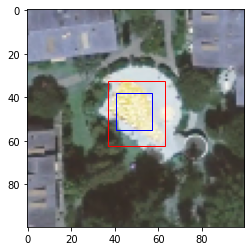

1/1 [==============================] - 0s 103ms/step
[0.4476237  0.42972705 0.5541954  0.5328005 ]


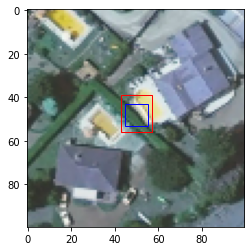

1/1 [==============================] - 0s 91ms/step
[0.4197222  0.39409712 0.583594   0.54326034]


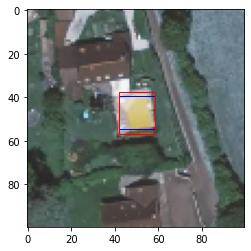

1/1 [==============================] - 0s 83ms/step
[0.42055327 0.4162685  0.55747056 0.53779674]


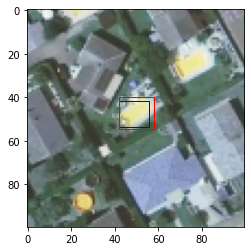

In [18]:
from tensorflow import expand_dims
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

for im_num in [523, 23, 189, 234, 94]:
    testing_image = expand_dims(preprocess_input(X[im_num]), axis=0)
    prediction = model.predict(testing_image)[0]
    print(prediction)
    fig, ax = plt.subplots()
    ax.imshow(X[im_num], vmin=0, vmax=1)

    rect = patches.Rectangle([prediction[0]*100,prediction[1]*IMAGE_SIZE], \
                             (prediction[2]-prediction[0])*IMAGE_SIZE, \
                             (prediction[3]-prediction[1])*IMAGE_SIZE, linewidth=1, edgecolor='blue', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    rect2 = patches.Rectangle([y[im_num][0]*IMAGE_SIZE,y[im_num][1]*IMAGE_SIZE], \
                             (y[im_num][2]-y[im_num][0])*IMAGE_SIZE, \
                             (y[im_num][3]-y[im_num][1])*IMAGE_SIZE, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect2)

    plt.show() 